<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Copy_of_Analytic_Signals_for_Audio_and_Radio_pitch_shifting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When doing signal processing *theory* it's often easier to work with the signal $\exp(i\omega t)$ than $\cos(\omega t)$ - for example the exponential diagonalises many of the operations we care about. But in *practice* we usually think of signals as real-valued and for that we often rewrite $\cos(i\omega t)$ as $\frac{1}{2}(\exp(i\omega t)+\exp(-i\omega t))$.

More generally, given some signal $x(t)$ we sometimes would like to express it as the sum of two parts, one which is a sum of just positive frequency components and one with with negative frequency components. Given some signal we'd like some kind of procedure that can give us the missing piece we need to add to it so that we get the positive frequency part.

There's a pair of neat mathematical results:

$$
\int_{-\infty}^{\infty}\frac{\cos(\omega x)}{y-x}dx=\pi\sin(\omega y)
$$

and

$$
\int_{-\infty}^{\infty}\frac{\sin(\omega x)}{y-x}dx=-\pi\cos(\omega y)
$$

where the integrals are interpreted as *principal values*.

This is just what we need! If we convolve a sum of cos/sin waves with $\frac{i}{\pi x}$ it will give us the missing piece we need to add to the original signal to get a sum of positive frequency exponentials. For example, convolving $\sin(\omega t)$ will give $-i\cos(\omega t)$. $sin(\omega t)-i\cos(\omega t)$ is $-i\exp(i\omega t)$. For $\omega>0$ this has only positive frequencies as desired.

Importantly, we can approximate this with discrete samples using discrete convolution. So we can take audio samples, say, and rewrite them as the real part of a complex signal having only positive frequency parts.

First, let's download some royalty free music as our signal:

In [ ]:
# From https://pixabay.com
!wget https://cdn.pixabay.com/download/audio/2023/12/21/audio_136585036a.mp3

--2024-01-06 22:52:58--  https://cdn.pixabay.com/download/audio/2023/12/21/audio_136585036a.mp3
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3175653 (3.0M) [audio/mpeg]
Saving to: ‘audio_136585036a.mp3.1’

audio_136585036a.mp 100%[===================>]   3.03M  9.54MB/s    in 0.3s    

2024-01-06 22:52:59 (9.54 MB/s) - ‘audio_136585036a.mp3.1’ saved [3175653/3175653]



In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
import numpy as np
import IPython.display as ipd
import scipy
import matplotlib.pyplot as plt
import math

In [ ]:
# Thanks ChatGPT!

def mp3_to_numpy(file_path):
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())

    return samples[::2]

file_path = '/content/audio_136585036a.mp3'
audio_samples = mp3_to_numpy(file_path)

# Pick a subsection
samples = audio_samples[100000:500000]

Test to see if it works...

In [ ]:
ipd.Audio(samples, rate=44100)

Now build an approximation of our $1/x$ kernel.

In [ ]:
i = np.arange(-2000, 2000, dtype=np.float32)
kernel = np.where(i==0, 0, 1. / i)

<ipython-input-21-6f3a95c27e70>:2: RuntimeWarning: divide by zero encountered in divide
  kernel = np.where(i==0, 0, 1. / i)


Now test it.

We'll start with the 400 Hz signal $\cos(2\pi 400 t)$. After convolving with $\frac{1}{\pi t}$ notice how the curve is almost indistinguishable from $\sin(2\pi 400 t)$.

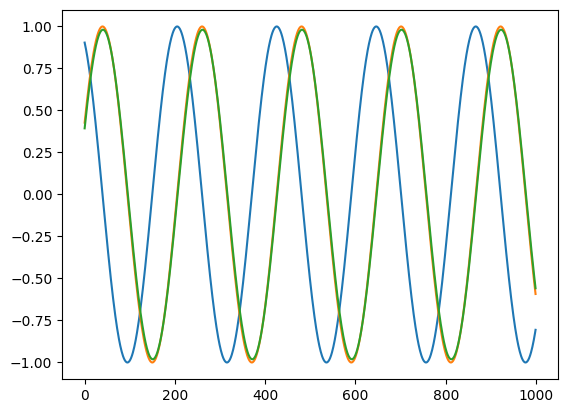

In [ ]:
t = np.arange(0, samples.shape[0]) / 44100
cost = np.cos(400 * math.pi * t)
sint = np.sin(400 * math.pi * t)
y = scipy.signal.convolve(cost, kernel / math.pi, mode='same')

# Start at sample 2000 so we don't get effects from colvolving past the edge of
# the signal.
plt.plot(cost[2000:3000])
plt.plot(sint[2000:3000])
plt.plot(y[2000:3000])

Now here's a fun thing we can do. If a signal is a sum of complex exponentials

$x(t) = \sum_i a_i exp(i\omega_i t)$

then we can ptch shift it by $\omega$ simply by multiplying by $\exp(i\omega t)$.

Our signal becomes

$\sum_i a_i exp(i(\omega_i+\omega)t)$

First a test with no pitch shifint.

In [ ]:
y = samples + 1j * scipy.signal.convolve(samples, kernel / math.pi, mode='same')
twist = np.exp(2 * math.pi * 0 * 1j * t)
ipd.Audio(np.real(twist[2000:-2000] * y[2000:-2000]), rate=44100)

Now the pitch shifted version.

Somethings to note:

Melodies are about ratios of frequencies. By adding the same shift to every note we break the melody.

But also, the timbre of most instruments in both classical and pop music (strings, woodwinds, analogue or digital synths using substractive synthesis) is determined by the fact that there is a fundamental, a first overtone at double the frequency, a second overtone at triple the frequency and so on. As well as ruining our melodies we also ruin the ratios of the overtones. Bells and chimes tend to have more complex relationships and so every instrument now sounds like a bell or chime!

In [ ]:
y = samples + 1j * scipy.signal.convolve(samples, kernel / math.pi, mode='same')
twist = np.exp(2 * math.pi * 500 * 1j * t)
ipd.Audio(np.real(twist[2000:-2000] * y[2000:-2000]), rate=44100)

We can also reduce the pitch. Sort of gong-like.

In [ ]:
y = samples + 1j * scipy.signal.convolve(samples, kernel / math.pi, mode='same')
twist = np.exp(-2 * math.pi * 200 * 1j * t)
ipd.Audio(np.real(twist[2000:-2000] * y[2000:-2000]), rate=44100)

It's really nice that we can change the pitch without changing the overall speed of the music. But as you can hear, it's not great for *music* unless you want these kinds of dissonant effects.

There's a whole other approach to this which is to take the Fourier transform of the original signal, throw away the part corresponding to the negative frequencies, and then take the inverse Fourier transform. In fact the use of `scipy.signal.convolve` may actually be taking approximately this path.

Convolution with $\frac{1}{\pi x}$ is usually known as the [Hilbert Transform](https://en.wikipedia.org/wiki/Hilbert_transform).

The place where this is important is in radio. For example, when working with [software-defined radio](https://www.rtl-sdr.com/) the samples the hardware gives to the software are already the complex positive frequency signal. The real part is called the "in-phase" part (I) and the imaginary part is called "quadrature" (Q). This is the technique that makes it possible to receive a signal around 5 GHz, say, and shift the frequencies down to around 0 Hz, to make it possible to work with the samples on a computer running at 1 or 2 GHz.

You can see some discussion about this here: https://play.fallows.ca/wp/radio/software-defined-radio/sdr-receiver-quadrature-signals-information/ But also compare with good old fashioned [heterodyning](https://en.wikipedia.org/wiki/Heterodyne).

I have some old but real working FM demodulation code that makes use of I and Q here: https://github.com/dpiponi/mini_fm/blob/master/mini_fm.cpp In FM radio, the audio signal is encoded as the rate of change of the phase of the complex signal. This makes it invariant to changes of amplitude and reasonably robust against a wide range of types of noise.

It seems unlikely, but there's also a big analogy with the machinery behind the dual problem in optimization. I've not seen anything written about this connection apart from what I wrote on the [math stack exchange](https://math.stackexchange.com/a/639945/80). At some point I'll write in a single place about both sides of the analogy and explicitly point out the connection...